#Initial games: build dataset and adapt MNIST example code 

###Figure out what the format is: flattened bitmap

In [1]:
import pickle
import gzip

with gzip.open('lib/Lasagne/examples/mnist.pkl.gz', 'rb') as f:
    data = pickle.load(f)

In [2]:
X_train, y_train = data[0]
X_valid, y_valid = data[1]
X_test, y_test = data[2]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


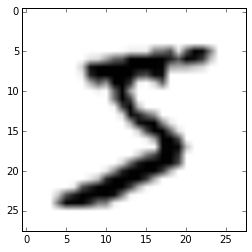

In [3]:
%pylab inline
plt.imshow(X_train[0].reshape(28, 28), get_cmap('binary'))

###Translate album covers to same format

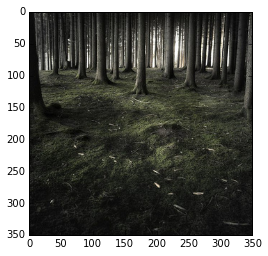

In [4]:
arr = plt.imread('data/deep-learning-sample/ambient/a1003262118.jpg')
plt.imshow(arr)

In [5]:
arr = arr.astype(np.int32)
arr_gray = (arr[:,:,0] << 16) + (arr[:,:,1] << 8) + arr[:,:,2]

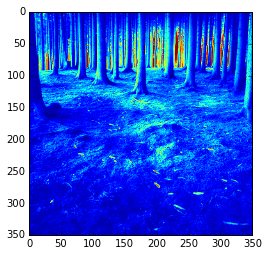

In [7]:
import skimage.io
plt.imshow(skimage.io.imread('data/deep-learning-sample/ambient/a1003262118.jpg', as_grey=True))

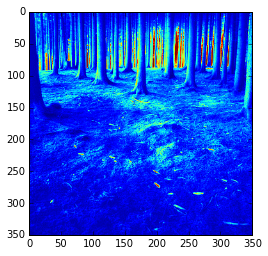

In [8]:
plt.imshow(arr_gray)

###A pretty sample

In [10]:
import os
from IPython.display import display, HTML, Image

for root, _, filenames in os.walk('data/deep-learning-sample'):
    if not filenames:
        continue
    random.shuffle(filenames)
    genre = os.path.basename(root)
    display(HTML('<h3>%s</h3>' % genre))
    display(HTML(''.join('<img src="%s" width="75" height="75" '
                         'style="display: inline-block; margin: 0">' % os.path.join(root, filename)
                         for filename in filenames[:24])))

##Create datasets

**Full dataset (for remote gpu experiments):**
* 8,000 training
* 1,000 validation
* 1,000 test

**Local development dataset (subset of 8,000 training):**
* 800 training
* 100 validation
* 100 test

In [19]:
import data
data.collect_dataset_filenames()

In [1]:
import data
dataset, label_to_index = data.load_dataset('data/local-dataset-filenames.json')
sorted(label_to_index.iteritems())

[(u'ambient', 0),
 (u'dubstep', 1),
 (u'folk', 2),
 (u'hiphop_rap', 3),
 (u'jazz', 4),
 (u'metal', 5),
 (u'pop', 6),
 (u'punk', 7),
 (u'rock', 8),
 (u'soul', 9)]

In [42]:
for subset, (instances, labels) in dataset.iteritems():
    assert instances.shape[0] == len(labels)
    print subset, instances.shape

training (800, 122500)
validation (100, 122500)
testing (100, 122500)


###Baselines

In [43]:
from sklearn.dummy import DummyClassifier

estimator = DummyClassifier('most_frequent')
estimator.fit(*dataset['training'])
print estimator.score(*dataset['validation'])
print estimator.score(*dataset['testing'])

0.1
0.1


In [44]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=1000)
estimator.fit(*dataset['training'])
print estimator.score(*dataset['validation'])
print estimator.score(*dataset['testing'])

0.14
0.15


###Basic net (based on mnist lasagne demo)

* adapted from `Lasagne/examples/mnist.py`

In [31]:
lasagne_dataset = data.create_lasagne_dataset(dataset, label_to_index)
lasagne_dataset

{'X_test': <TensorType(float64, matrix)>,
 'X_train': <TensorType(float64, matrix)>,
 'X_valid': <TensorType(float64, matrix)>,
 'input_dim': 122500,
 'num_examples_test': 100,
 'num_examples_train': 800,
 'num_examples_valid': 100,
 'output_dim': 10,
 'y_test': <TensorType(int32, vector)>,
 'y_train': <TensorType(int32, vector)>,
 'y_valid': <TensorType(int32, vector)>}

In [38]:
import architectures
import modeling

batch_size = 100
output_layer = architectures.build_model('mlp',
                                         input_dim=theano_dataset['input_dim'],
                                         output_dim=theano_dataset['output_dim'],
                                         batch_size=batch_size)
iter_funcs = modeling.create_iter_functions(lasagne_dataset, output_layer)

In [37]:
import experiment

experiment.run_experiment(iter_funcs=iter_funcs, lasagne_dataset=lasagne_dataset, batch_size=batch_size)

Epoch 1 of 500 took 30.764s
	training loss:		 53481.935003
	validation loss:		 5.822127
	validation accuracy:		 10.00%
Epoch 2 of 500 took 30.743s
	training loss:		 1673.699224
	validation loss:		 2.422652
	validation accuracy:		 11.00%
Epoch 3 of 500 took 28.497s
	training loss:		 3.380113
	validation loss:		 2.451046
	validation accuracy:		 10.00%
Epoch 4 of 500 took 28.934s
	training loss:		 2.733985
	validation loss:		 2.340774
	validation accuracy:		 10.00%
Epoch 5 of 500 took 28.268s
	training loss:		 2.303466
	validation loss:		 2.316075
	validation accuracy:		 10.00%


###Restructed to be runnable from command line

In [34]:
!python experiment.py run_experiment --dataset-json ./data/local-dataset-filenames.json -a mlp

/home/yanir/.virtualenvs/bandcamp-deep-learning/local/lib/python2.7/site-packages/Lasagne-0.1dev-py2.7.egg/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/home/yanir/.virtualenvs/bandcamp-deep-learning/local/lib/python2.7/site-packages/Lasagne-0.1dev-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "
Epoch 1 of 500 took 22.044s
	t